# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Tue Jun 22 18:15:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 272 (delta 56), reused 38 (delta 19), pack-reused 171
Receiving objects: 100% (272/272), 79.66 KiB | 2.21 MiB/s, done.
Resolving deltas: 100% (118/118), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla P100-PCIE-16GB!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,185 kB]
Ign:12 https://developer.download.nvidia.com/compute/

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:30
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL,
!python rapidsai-csp-utils/colab/install_rapids.py stable

Installing RAPIDS Stable 21.06
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.2.0                |   py37h89c1867_0         138 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0      

# cuDF and cuML Examples #

Now you can run code!

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [ ]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
6    15.622920
1    21.729202
4    14.594901
3    15.215685
2    16.571919
5    14.149549
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)#

This snippet loads a

As above, all calculations are performed on the GPU.

In [ ]:
import cuml

# Create and populate a GPU DataFrame
df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]
df_float['2'] = [4.0, 2.0, 1.0]

# Setup and fit clusters
dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [ ]:
!pip install "autogluon.tabular[all]==0.1.1b20210312"
!pip install AutoViz
!pip install xlrd

     |████████████████████████████████| 234 kB 3.0 MB/s 
     |████████████████████████████████| 280 kB 12.5 MB/s 
     |████████████████████████████████| 14.8 MB 304 kB/s 
     |████████████████████████████████| 48 kB 6.3 MB/s 
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 312 kB 76.7 MB/s 
     |████████████████████████████████| 449 kB 73.6 MB/s 
     |████████████████████████████████| 65.7 MB 15 kB/s 
     |████████████████████████████████| 157.5 MB 23 kB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
     |████████████████████████████████| 2.0 MB 80.5 MB/s 
     |████████████████████████████████| 239 kB 91.2 MB/s 
     |████████████████████████████████| 81 kB 12.5 MB/s 
     |████████████████████████████████| 2.0 MB 85.3 MB/s 
     |████████████████████████████████| 206 kB 68.2 MB/s 
     |████████████████████████████████| 131 kB 73.3 MB/s 
     |████████████████████████████████| 950 kB 58.4 MB/s 
  Installing build

     |████████████████████████████████| 9.5 MB 3.4 MB/s 
     |████████████████████████████████| 285 kB 68.4 MB/s 
     |████████████████████████████████| 119 kB 62.4 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 231 kB 67.2 MB/s 
     |████████████████████████████████| 96 kB 2.2 MB/s 


In [ ]:
import pandas as pd
dfe = pd.read_csv('/content/train.csv')

from autoviz.AutoViz_Class import AutoViz_Class

#Instantiate the AutoViz class
AV = AutoViz_Class()

In [ ]:
dfe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


Shape of your Data Set: (100000, 12)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  2
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  2
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    11 Predictors classified...
        This does not include the Target column(s)
        3 variables removed since they were ID or low-information variables
Since Number of Rows in data 100000 exceeds maximum, randomly sampling 100000 rows for EDA...

################ Binary_Classification VISUALIZATION Started #####################


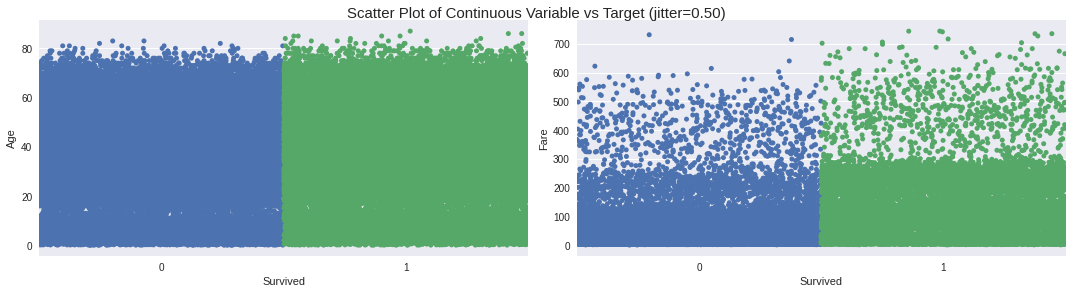

Total Number of Scatter Plots = 3


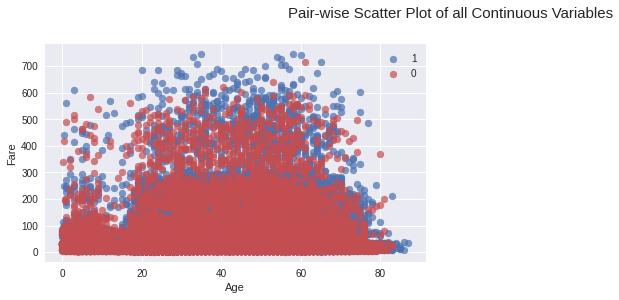

Could not draw Distribution Plots


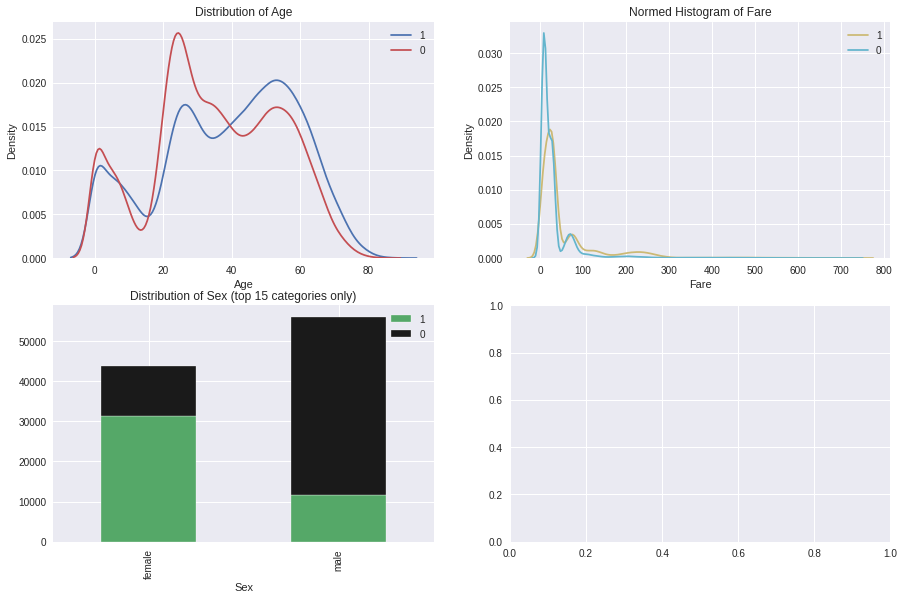

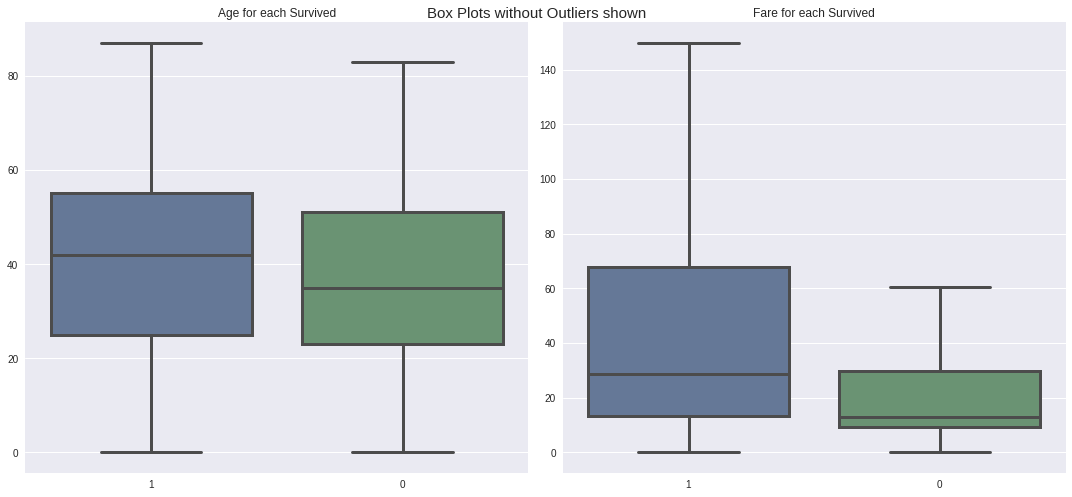

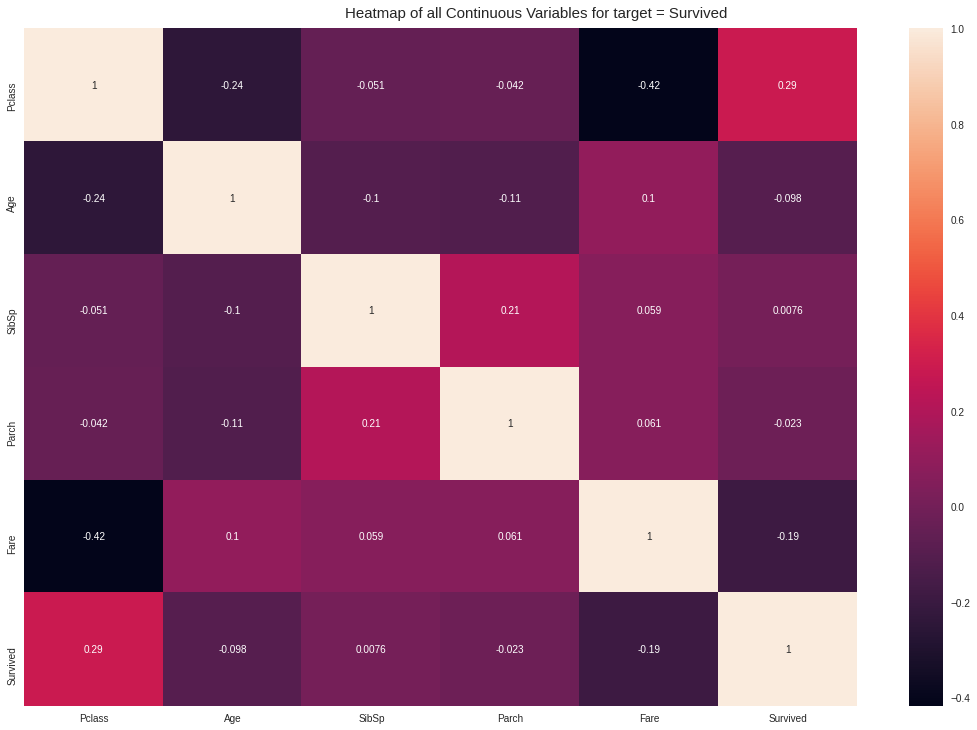

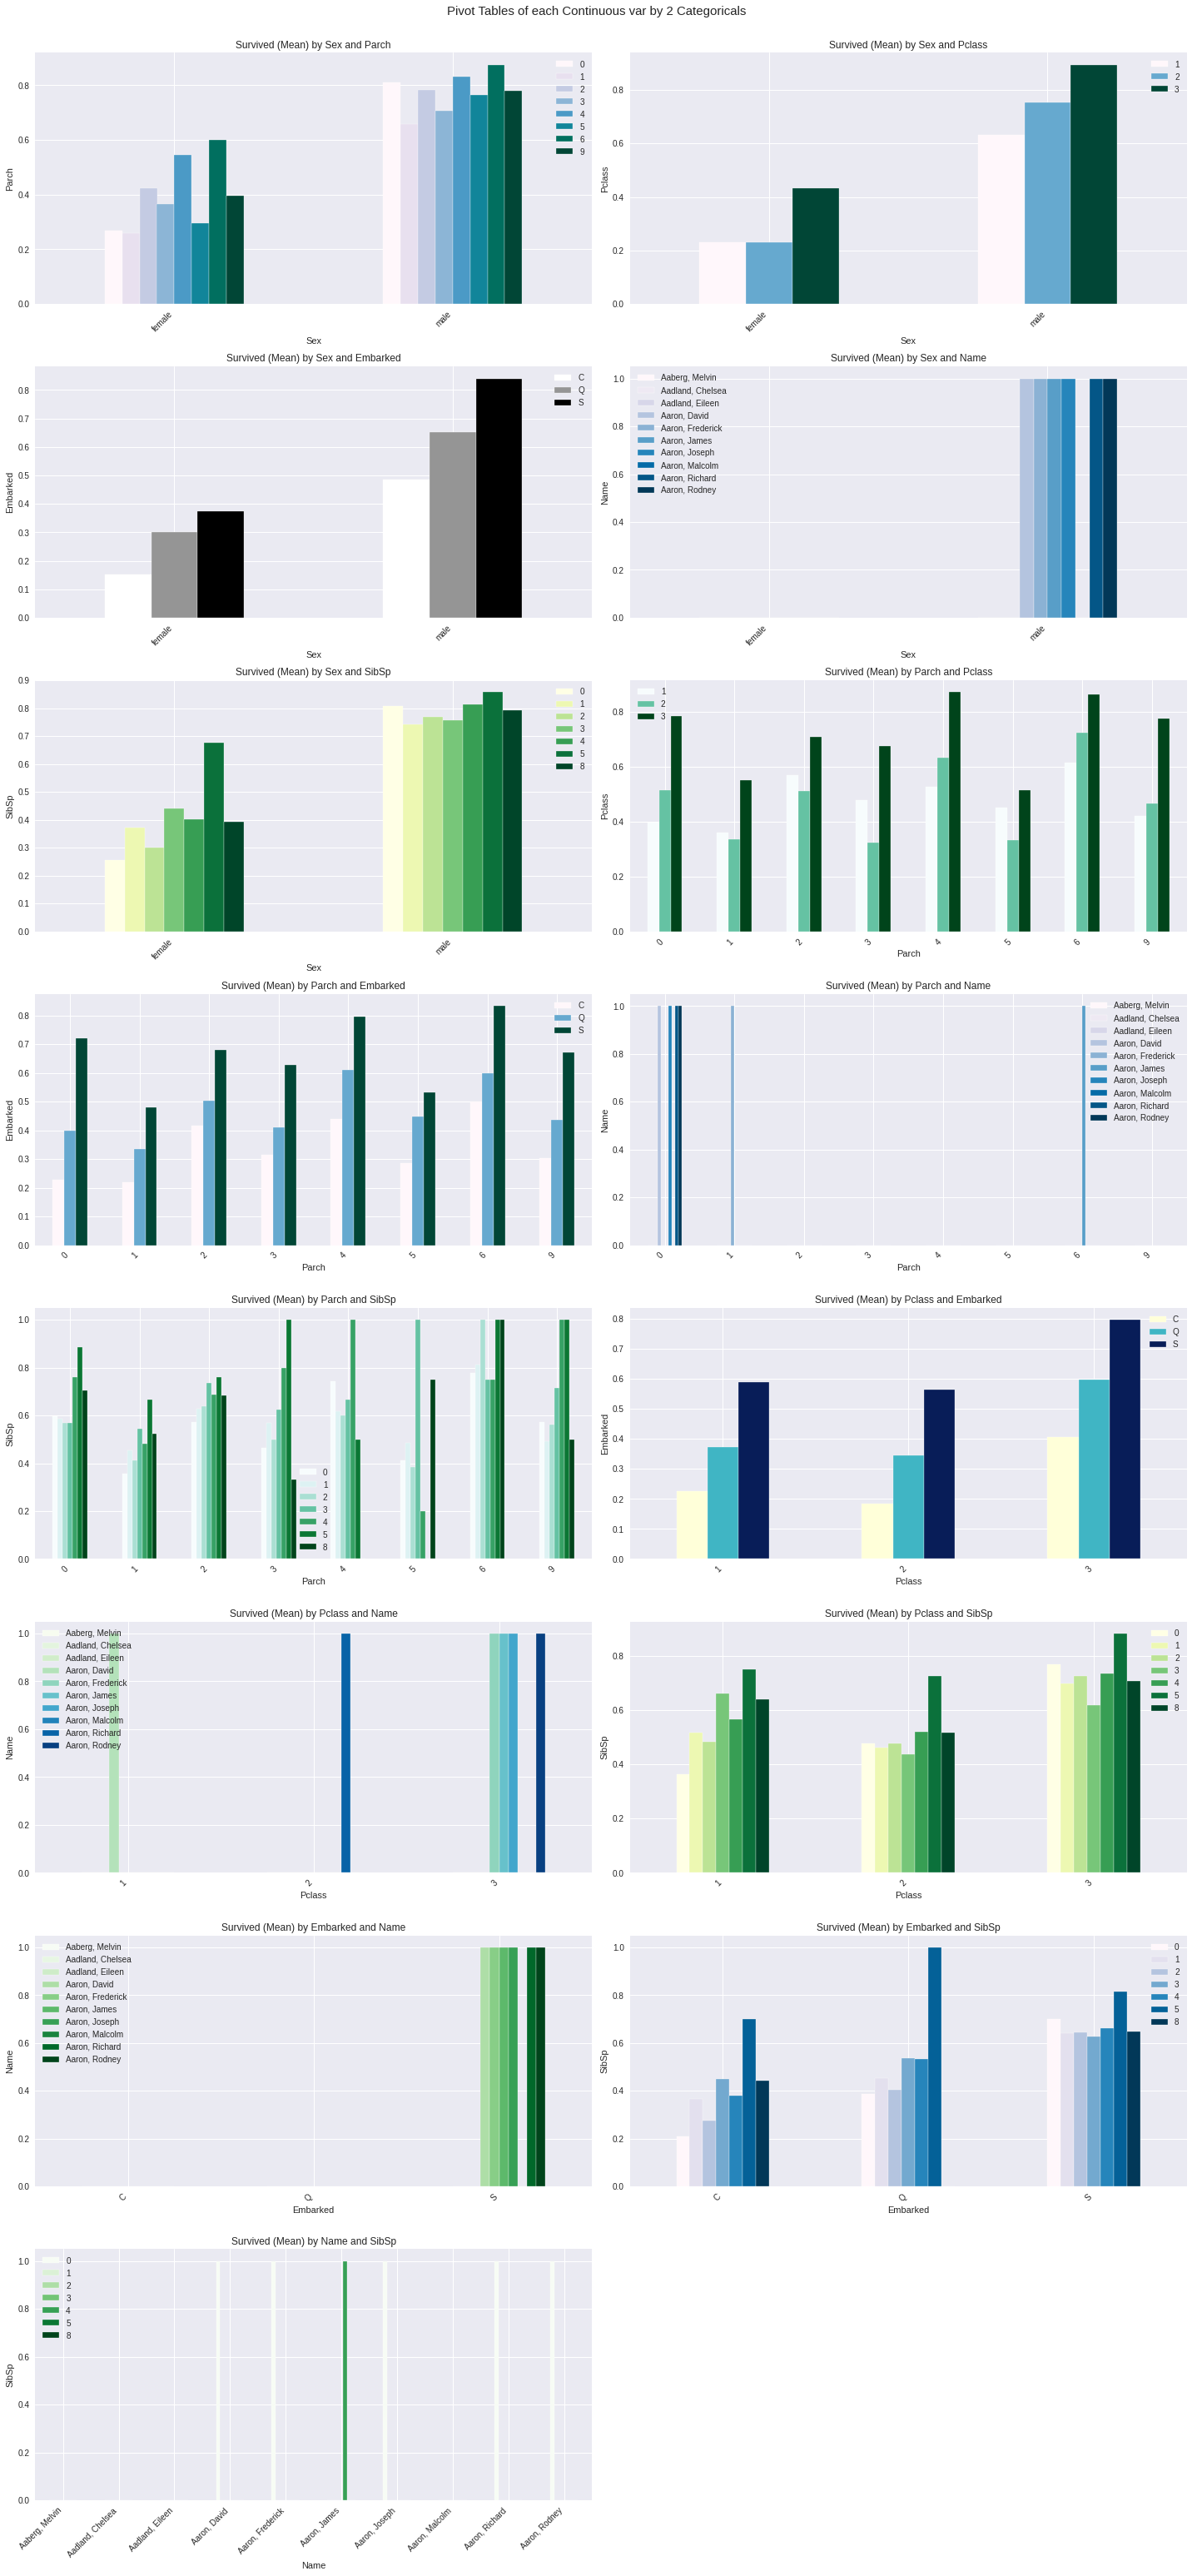

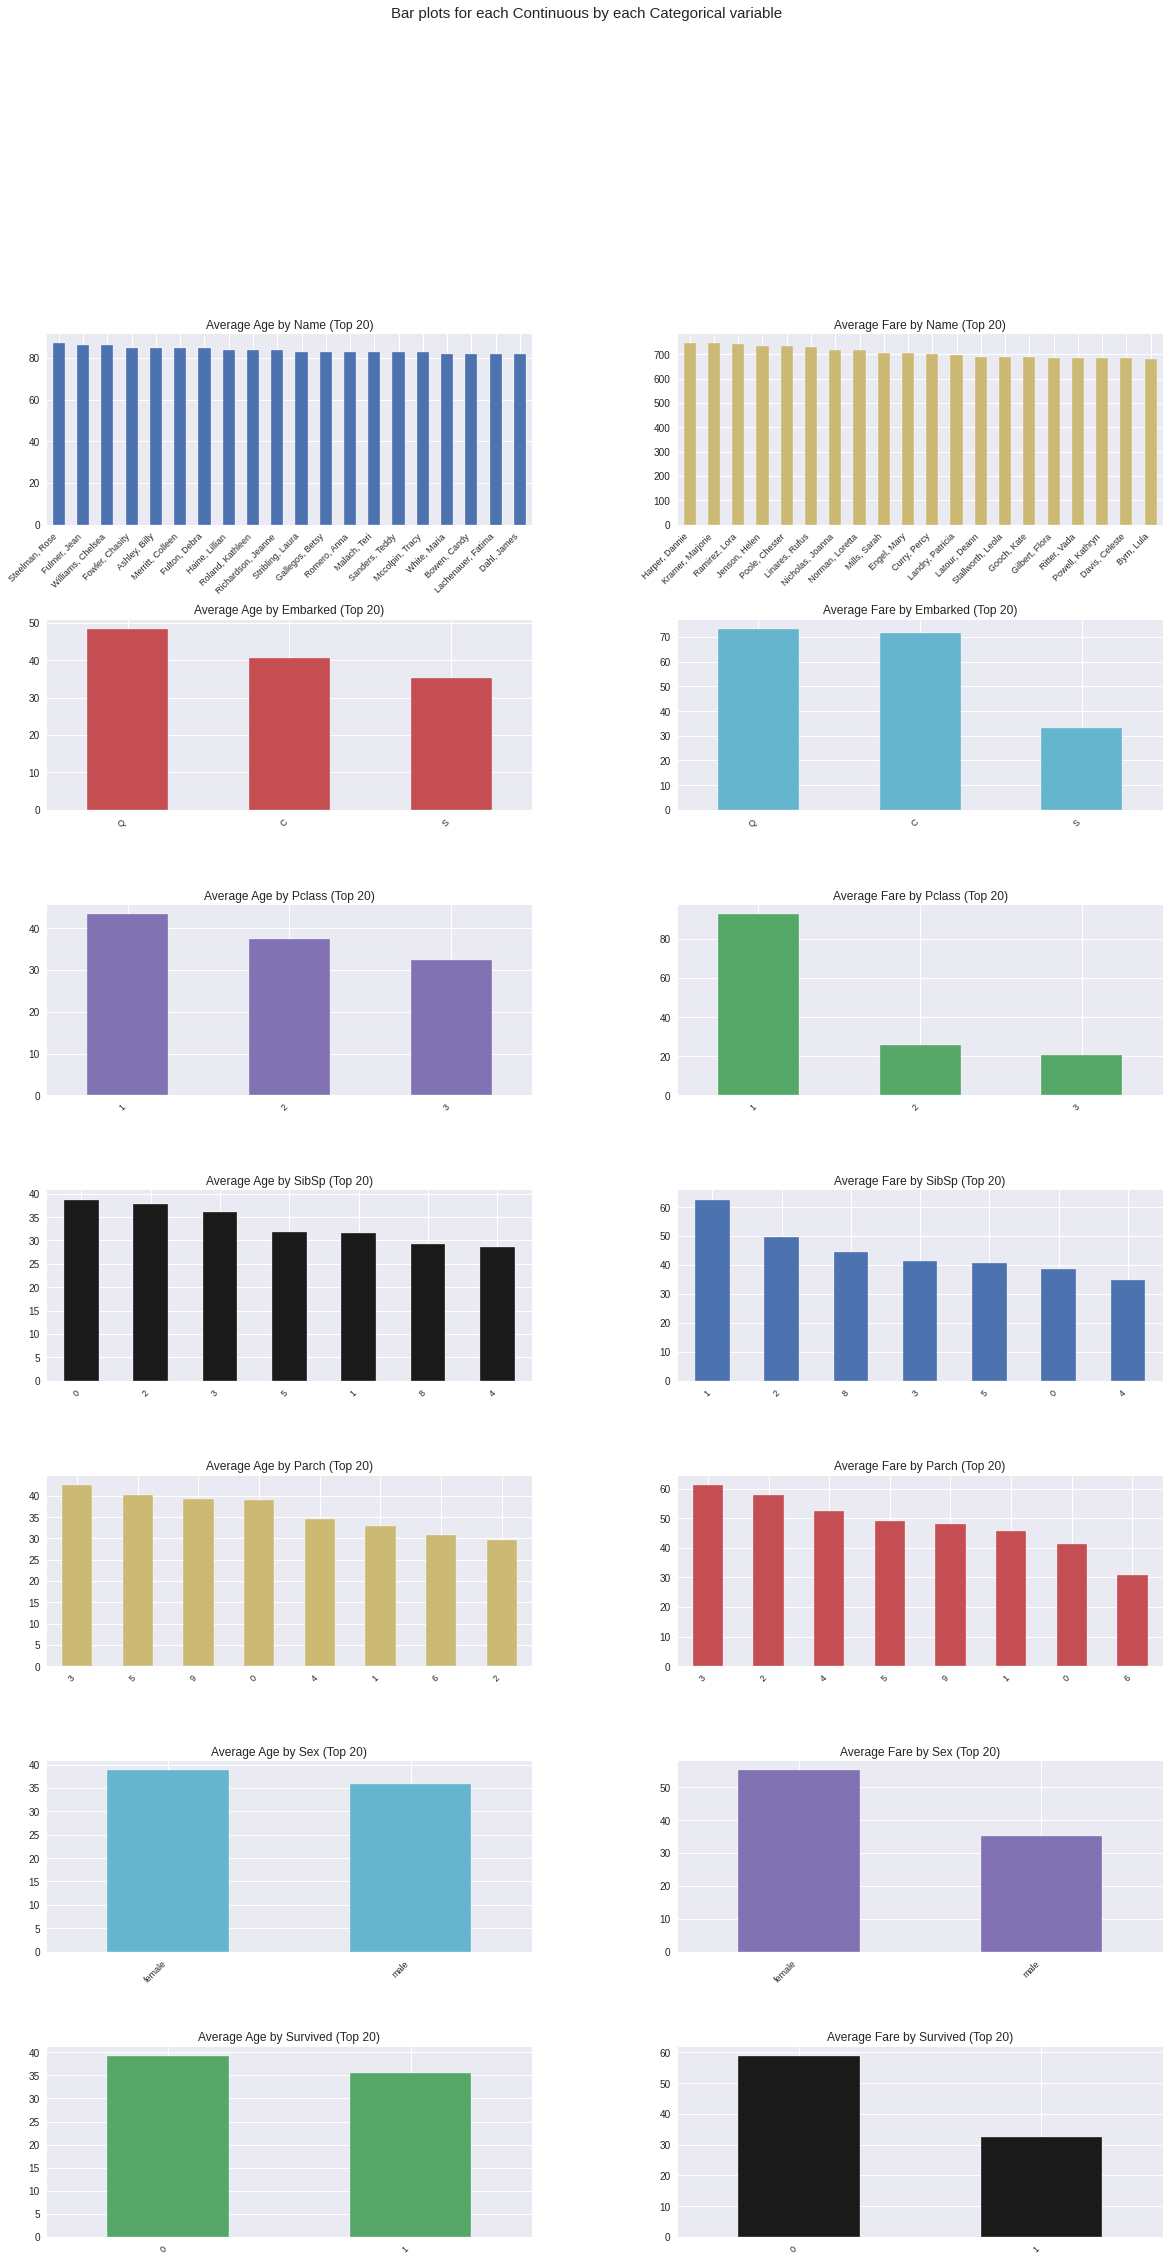

Time to run AutoViz (in seconds) = 14.904

 ###################### VISUALIZATION Completed ########################


In [ ]:
dftc = AV.AutoViz(filename='',
                  sep ='' ,
                  depVar ='Survived',
                  dfte = dfe,
                  header = 0,
                  verbose = 0,
                  lowess = False,
                  chart_format ='png',
                  max_rows_analyzed = 100000,
                  max_cols_analyzed = 30
)

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.tabular.models.lr.lr_rapids_model import LinearRapidsModel
from autogluon.tabular.models.knn.knn_rapids_model import KNNRapidsModel

train_data = TabularDataset('/content/train.csv')
test_data = TabularDataset('/content/test.csv')

label = 'Survived'

Loaded data from: /content/train.csv | Columns = 12 / 12 | Rows = 100000 -> 100000
Loaded data from: /content/test.csv | Columns = 11 / 11 | Rows = 100000 -> 100000


In [ ]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [ ]:
#using integrated RAPIDS models along with some boosting models
predictor = TabularPredictor(
    label=label,
    eval_metric='accuracy',
    learner_kwargs={'ignored_columns': ['PassengerId']}
).fit(
    train_data,
    presets='best_quality',
    hyperparameters={'XGB': {'ag_args_fit': {'num_gpus': 1}},
        'GBM': [{}, {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, 'GBMLarge'],
        'NN': {'ag_args_fit': {'num_gpus': 1}},
        'CAT': {'ag_args_fit': {'num_gpus': 1}},
        KNNRapidsModel: {},
        LinearRapidsModel: {},

    },
)

No path specified. Models will be saved in: "AutogluonModels/ag-20210622_192223/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210622_192223/"
AutoGluon Version:  0.1.1b20210312
Train Data Rows:    100000
Train Data Columns: 11
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['PassengerId']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22458.9 MB
	Train Data (Original)  Memory Usage: 34.29 MB (0.2% of available memory)
	Inferring data t

In [ ]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C


In [ ]:
import pandas as pd
submission = test_data[['PassengerId']]
test_pred_proba = predictor.predict(test_data)
test_pred_proba=pd.DataFrame(test_pred_proba,columns=['Survived'])
submission = pd.concat([submission, test_pred_proba], axis=1)
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1


In [ ]:
predictor.leaderboard(silent=True)